# Using the ml4qc package for a specific example analysis ("CAPI2")

This workbook demonstrates an example analysis for a particular CAPI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CAPI2".

This is a basic proof-of-concept project designed to explore the potential for ML-based tools to identify outliers and submissions that are likely to be rejected by a human reviewer. The project collected a wide range of metadata, and many submissions were reviewed.

**This workbook is a work in progress...**

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **mean_light_level** - Mean light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **sd_light_level** - Standard deviation of light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **mean_movement** - Mean device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **sd_movement** - Standard deviation of device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **mean_movement** - Mean sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **sd_movement** - Standard deviation of sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_quiet** - Percent of form-editing time when it was quiet ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_still** - Percent of form-editing time when the device was still ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **duration** - Total number of seconds spent editing form
* **TA** - Name of text audit `.csv` file
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID
* **enum** - ID of enumerator who conducted the interview

In [3]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Europe/Amsterdam").zone
collection_tz = pytz.timezone("Europe/Amsterdam").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("C:/Users/31653/Documents/GitHub/ml4qc/src/ml4qc-data/capi2/ids_capi2.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate        207
starttime             207
endtime               207
mean_light_level      163
sd_light_level        163
mean_movement          38
sd_movement            38
mean_sound_level      197
sd_sound_level        197
pct_quiet             197
pct_still             197
duration              207
TA                    207
review_quality        207
review_comments       207
review_corrections    207
review_status         207
reviewed              207
randomly_selected     207
n_flags               207
enum                  207
dtype: int64

Submission DataFrame review status and quality:
APPROVED    207
Name: review_status, dtype: Int64
OKAY    116
GOOD     91
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
device_time      167159
form_time_ms     167159
field            165595
event            167159
duration_ms      165595
Choice values     79389
Choice labels     79389
dtype: int64

Combined DataFrame field count

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using "submissions that are not APPROVED as GOOD quality" (i.e., rejected or another quality) as the target.

Here, we use PCA to reduce our feature dimensions, targeting 99% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [4]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.99

# random state for reproducible results (or None)
random_state = 411

analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "duration", "TA", "reviewed", "randomly_selected", "n_flags", "mean_movement", "sd_movement", "review_comments", "review_corrections", "enum"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality"]]
features_df = analysis_df.drop(["review_status", "review_quality"], axis=1)

# set our target for prediction
target_description = "Not APPROVED+GOOD"
classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped -44/207 observations with missing data, for a loss of -21.26%

Target description: Not APPROVED+GOOD
1    89
0    74
Name: target, dtype: int64

Target base rate: 54.60%

numeric features: 14836
numeric_binary features: 2350
numeric_unit_interval features: 12466
numeric_other features: 20
datetime features: 0
other features: 2
  Starting training set shape: (122, 14838)
Starting prediction set shape: (41, 14838)
     Final training set shape: (122, 113)
   Final prediction set shape: (41, 113)


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [5]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser("C:/Users/31653/Documents/GitHub/ml4qc/src/ml4qc-data/capi2/ids_capi2_outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 0 (0.0%)
CPU times: total: 4.09 s
Wall time: 4.17 s


target,0,1
is_outlier,,
0,1.0,1.0


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Logistic regression
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.7218173689019091
Parameters: {'C': 0.00012555975288865587, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

  Training set: (122, 113) (68 positive)
Prediction set: (41, 113)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  89.34%
         Train precision:  83.95%
     Train avg precision:  100.00%
               Train F-1:  0.91
     Prediction accuracy:  63.41%
    Prediction precision:  58.33%
Prediction avg precision:  73.48%
          Prediction F-1:  0.74
      Test ROC_AUC Score:  0.62

Cross validation results: 

fit_time: 0.0032422701517740887 (SD: 0.0005077643078793305)
score_time: 0.0035138607025146486 (SD: 0.0004989317514909486)
test_accuracy: 0.6035555555555555 (SD: 0.06

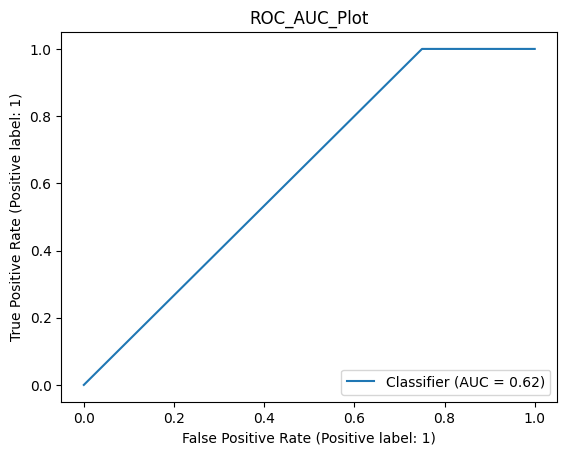

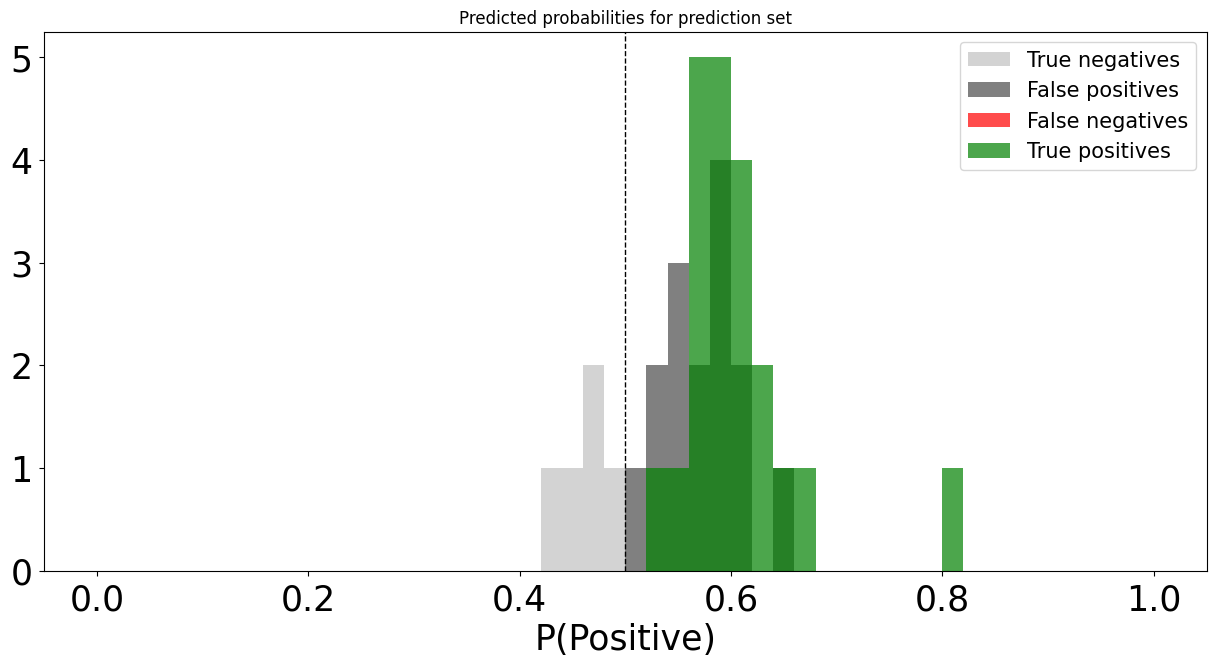

Test P(1) =  51.22%
Test P(1 | predicted 1) =  58.33%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        20
           1       0.58      1.00      0.74        21

    accuracy                           0.63        41
   macro avg       0.79      0.62      0.57        41
weighted avg       0.79      0.63      0.57        41



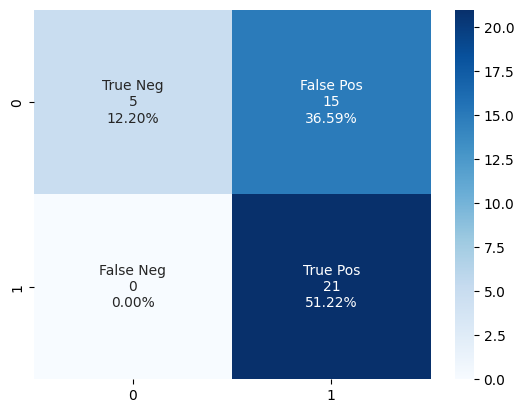

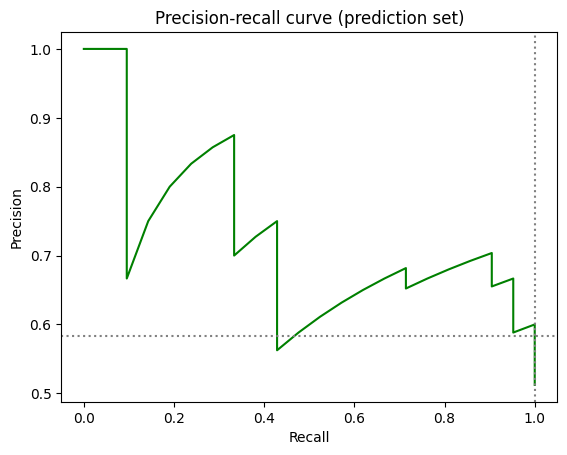

Predictions made: 41
CPU times: total: 2.62 s
Wall time: 8.04 s


In [6]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Decision tree
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.6553097912225047
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'class_weight': None}

Running prediction model...

  Training set: (122, 113) (68 positive)
Prediction set: (41, 113)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  69.67%
         Train precision:  65.05%
     Train avg precision:  68.87%
               Train F-1:  0.78
     Prediction accuracy:  56.10%
    Prediction precision:  54.29%
Prediction avg precision:  56.97%
          Prediction F-1:  0.68
      Test ROC_AUC Score:  0.55

Cross validation results: 

fit_time: 0.00126188596089681 (SD: 0.00043391584443491364)
score_time: 0.0034028371175130207 (SD: 0.0007637665004421955)
test_accu

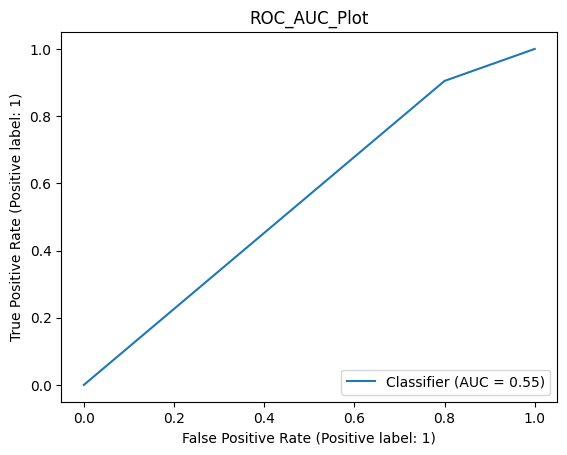

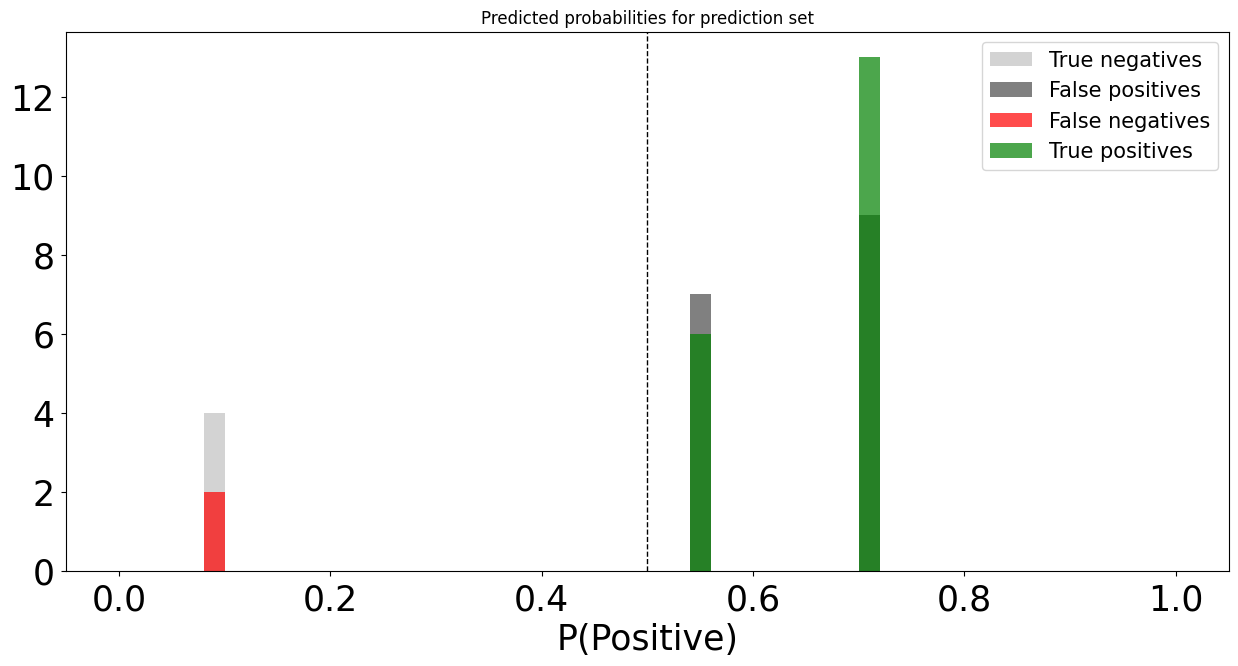

Test P(1) =  51.22%
Test P(1 | predicted 1) =  54.29%
Test P(1 | predicted 0) =  33.33%

              precision    recall  f1-score   support

           0       0.67      0.20      0.31        20
           1       0.54      0.90      0.68        21

    accuracy                           0.56        41
   macro avg       0.60      0.55      0.49        41
weighted avg       0.60      0.56      0.50        41



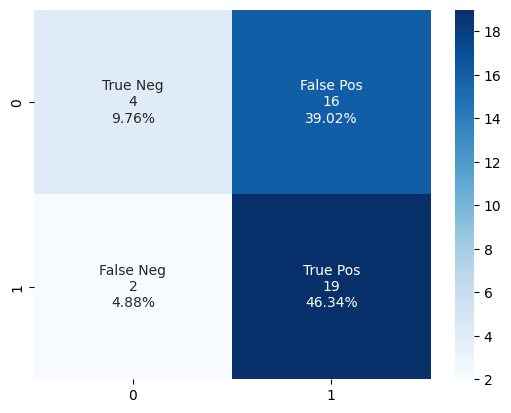

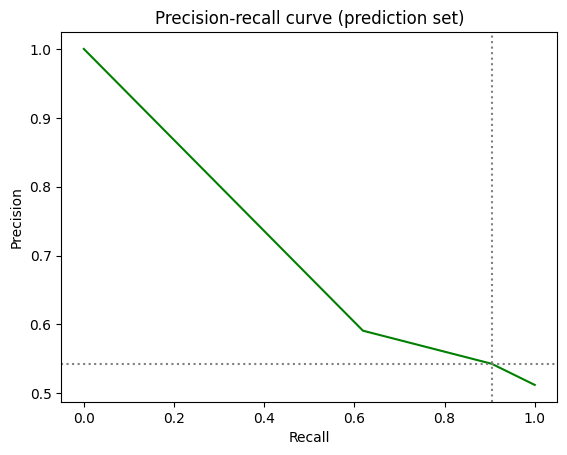

Predictions made: 41
CPU times: total: 1.89 s
Wall time: 2.02 s


In [7]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Random forest
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.670699356749325
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3, 'class_weight': None, 'bootstrap': True}

Running prediction model...

  Training set: (122, 113) (68 positive)
Prediction set: (41, 113)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  97.54%
         Train precision:  95.77%
     Train avg precision:  100.00%
               Train F-1:  0.98
     Prediction accuracy:  56.10%
    Prediction precision:  54.05%
Prediction avg precision:  71.00%
          Prediction F-1:  0.69
      Test ROC_AUC Score:  0.55

Cross validation results: 

fit_time: 1.619015645980835 (SD: 0.040647501532822636)
score_time: 0.1730978012084961 (SD: 0.016927280023682597)

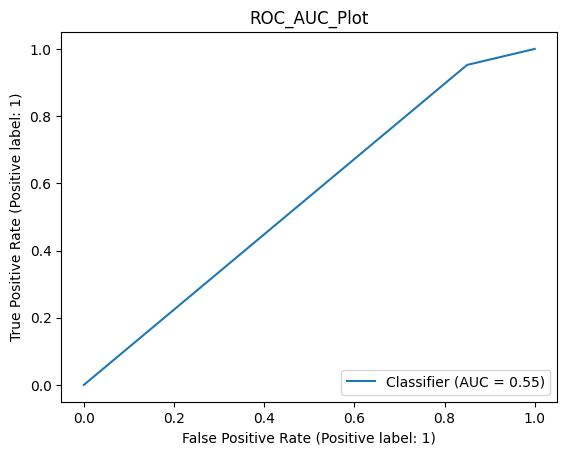

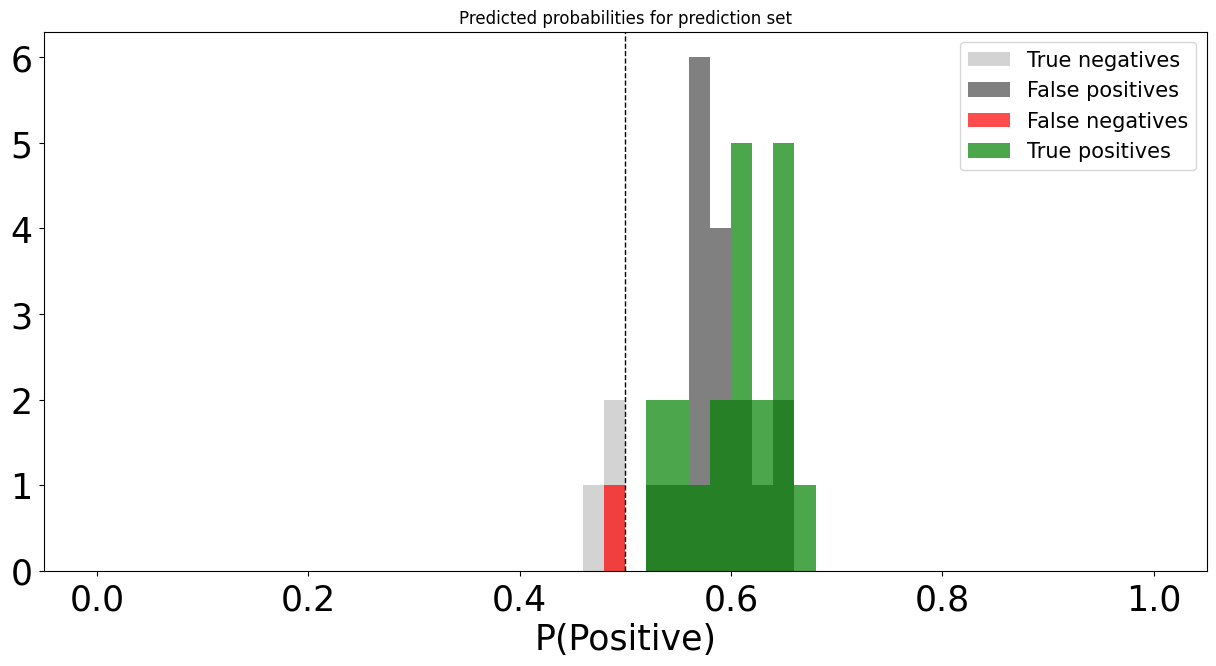

Test P(1) =  51.22%
Test P(1 | predicted 1) =  54.05%
Test P(1 | predicted 0) =  25.00%

              precision    recall  f1-score   support

           0       0.75      0.15      0.25        20
           1       0.54      0.95      0.69        21

    accuracy                           0.56        41
   macro avg       0.65      0.55      0.47        41
weighted avg       0.64      0.56      0.48        41



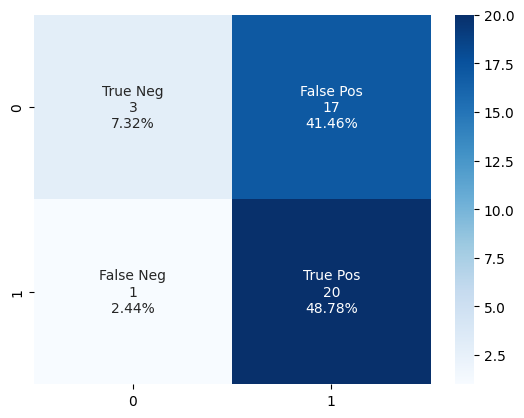

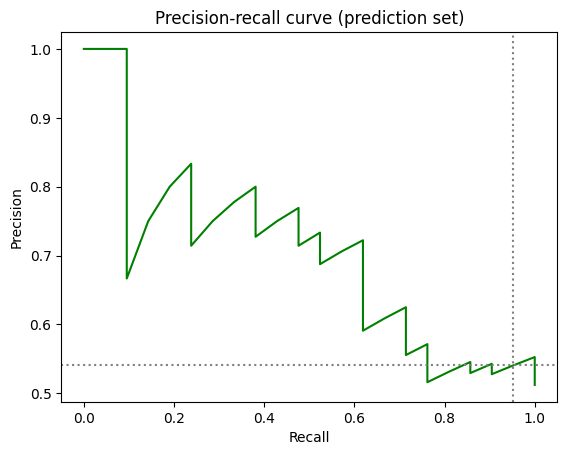

Predictions made: 41
CPU times: total: 8.48 s
Wall time: 27.4 s


In [8]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: XGBoost
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best f1: 0.6088114954755032
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 2, 'max_depth': 3}

Running prediction model...

  Training set: (122, 113) (68 positive)
Prediction set: (41, 113)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  100.00%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  60.98%
    Prediction precision:  60.00%
Prediction avg precision:  61.67%
          Prediction F-1:  0.65
      Test ROC_AUC Score:  0.61

Cross validation results: 

fit_time: 0.29766767819722495 (SD: 0.01142699562833388)
score_time: 0.01249839464823405 (SD: 0.004070333783264408)
test_accuracy: 0.5735555555555556 (SD: 0.0706998524

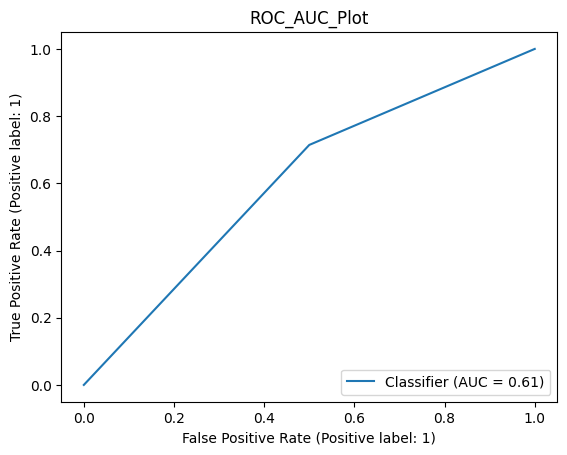

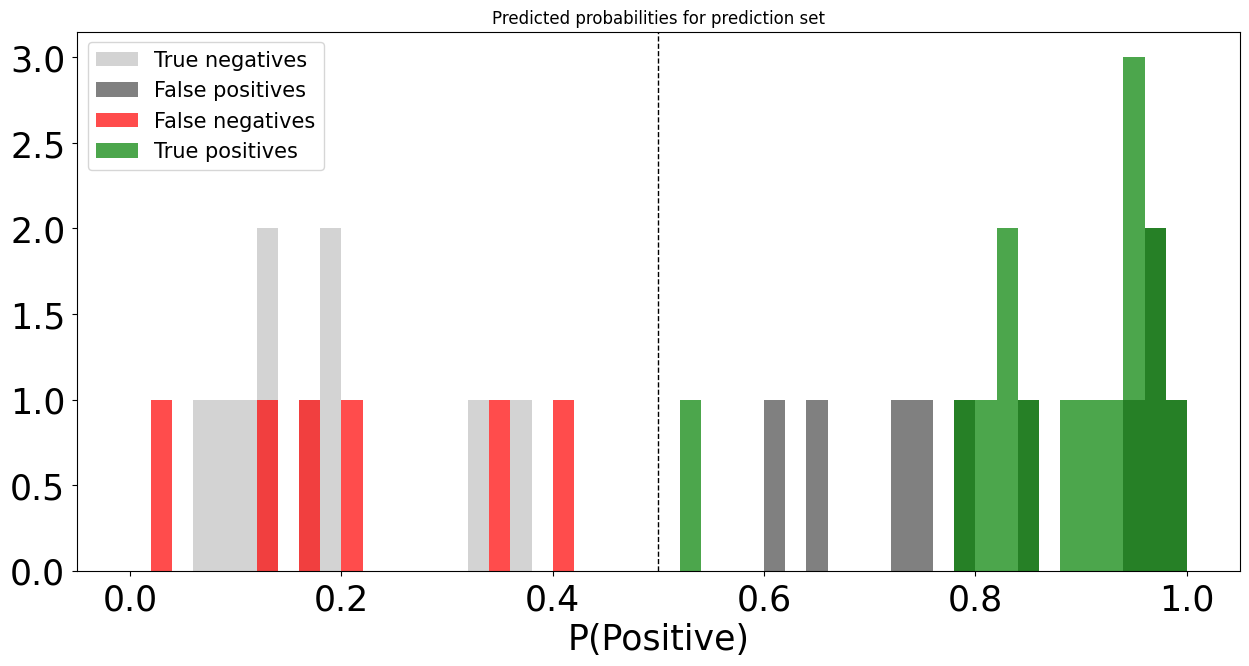

Test P(1) =  51.22%
Test P(1 | predicted 1) =  60.00%
Test P(1 | predicted 0) =  37.50%

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        20
           1       0.60      0.71      0.65        21

    accuracy                           0.61        41
   macro avg       0.61      0.61      0.60        41
weighted avg       0.61      0.61      0.61        41



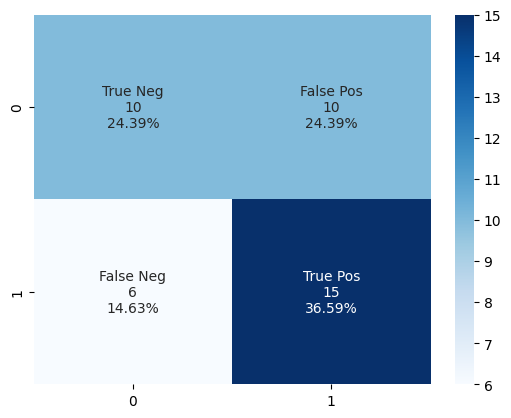

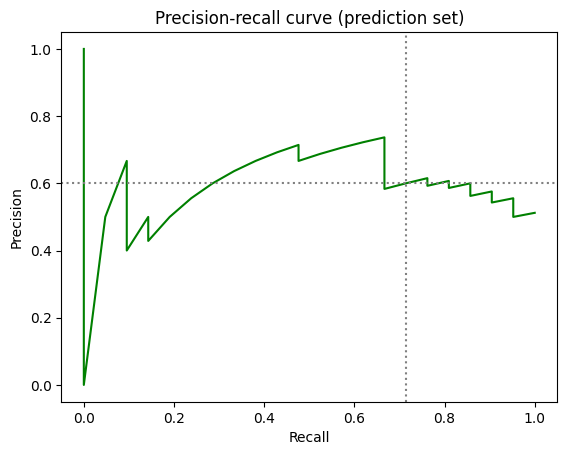

Predictions made: 41
CPU times: total: 9.38 s
Wall time: 10.2 s


In [9]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Neural network
     Scoring: f1

Running random CV search for best hyperparameters...

   Scoring: f1
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


C:\Users\31653\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best f1: 0.6996458706130806
Parameters: {'batch_size': 16, 'class_weight': None, 'epochs': 100, 'model__activation': 'sigmoid', 'model__dropout_rate': 0.35000000000000003, 'model__features': 113, 'model__hidden_layers': 1, 'model__include_dropout': False, 'model__initial_units': 56.5, 'model__l2_factor': 0.004558275577392365, 'model__l2_regularization': False, 'model__output_bias': None}

Running prediction model...

  Training set: (122, 113) (68 positive)
Prediction set: (41, 113)

Cross-validating model on training set...


Fitting model...

          Train accuracy:  100.00%
         Train precision:  100.00%
     Train avg precision:  100.00%
               Train F-1:  1.0
     Prediction accuracy:  68.29%
    Prediction precision:  63.33%
Prediction avg precision:  76.87%
          Prediction F-1:  0.75
      Test ROC_AUC Score:  0.68

Cross validation results: 

fit_time: 4.184436893463134 (SD: 0.12891353410107867)
score_time: 0.44950908025105796 (SD: 0.07389993309617739)
test_

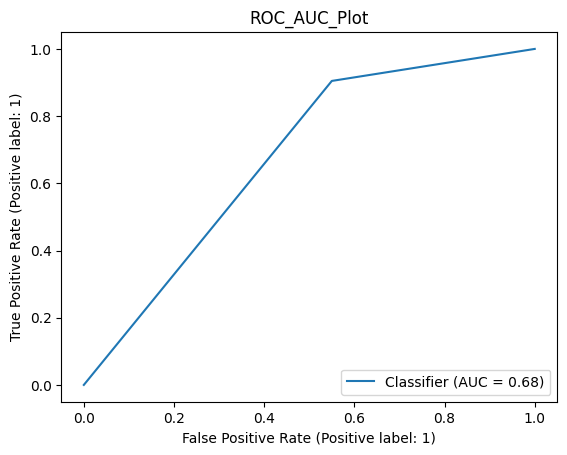

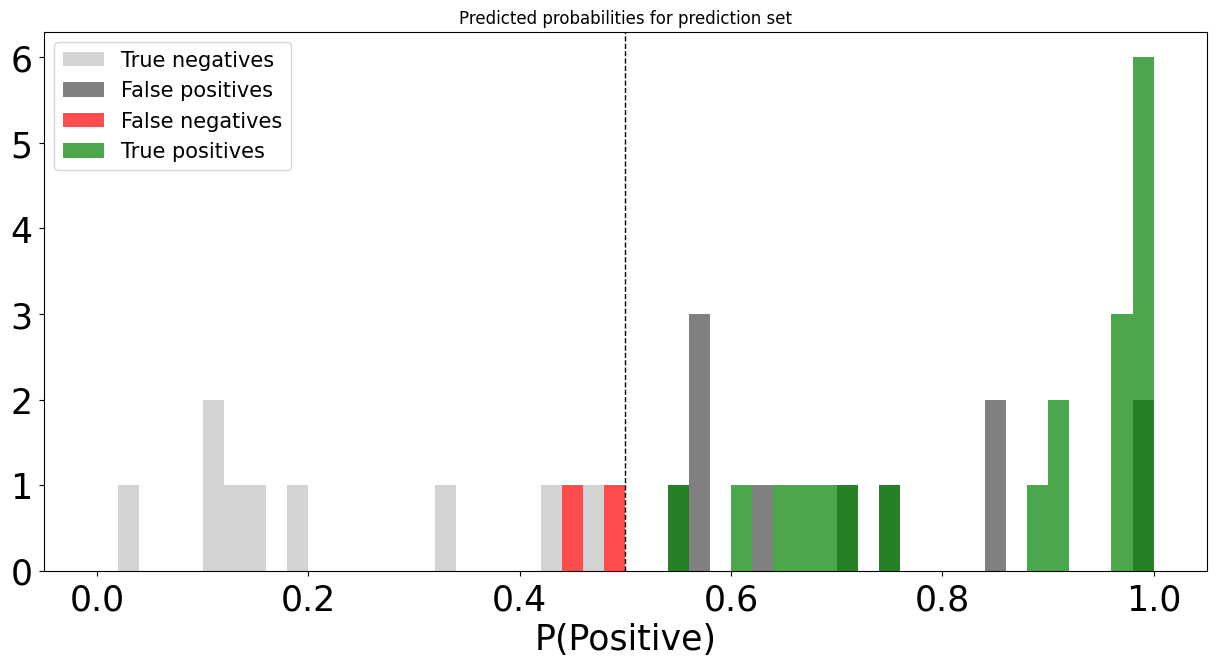

Test P(1) =  51.22%
Test P(1 | predicted 1) =  63.33%
Test P(1 | predicted 0) =  18.18%

              precision    recall  f1-score   support

           0       0.82      0.45      0.58        20
           1       0.63      0.90      0.75        21

    accuracy                           0.68        41
   macro avg       0.73      0.68      0.66        41
weighted avg       0.72      0.68      0.66        41



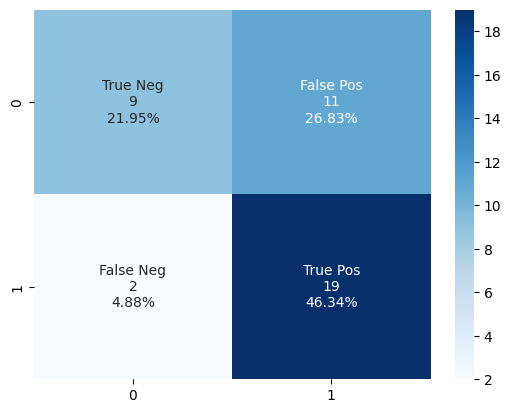

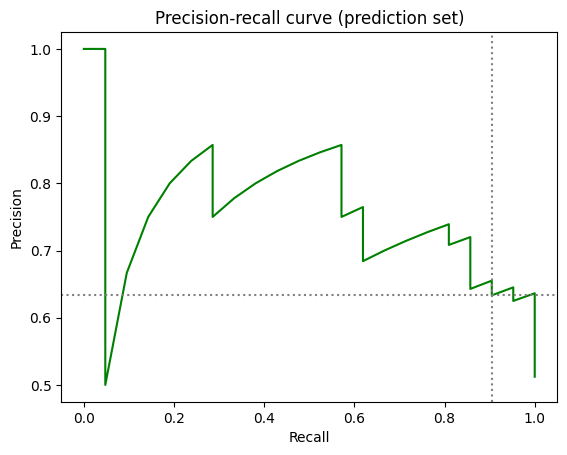

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 56)                6384      
                                                                 
 dense_3 (Dense)             (None, 1)                 57        
                                                                 
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________
None

Predictions made: 41
CPU times: total: 15.2 s
Wall time: 7min 30s


In [10]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import numpy as np
from scikeras.wrappers import KerasClassifier

# Option 1: use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
#   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -0.03172571075887665
# Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 40, 'model__activation': 'relu', 'model__dropout_rate': 0.45, 'model__features': 665, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 665, 'model__l2_factor': 0.0034877930278527348, 'model__l2_regularization': True, 'model__output_bias': None}
# params = {'batch_size': 32, 'class_weight': None, 'epochs': 40, 'model__activation': 'relu', 'model__dropout_rate': 0.45, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.0034877930278527348, 'model__l2_regularization': True, 'model__output_bias': None}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")